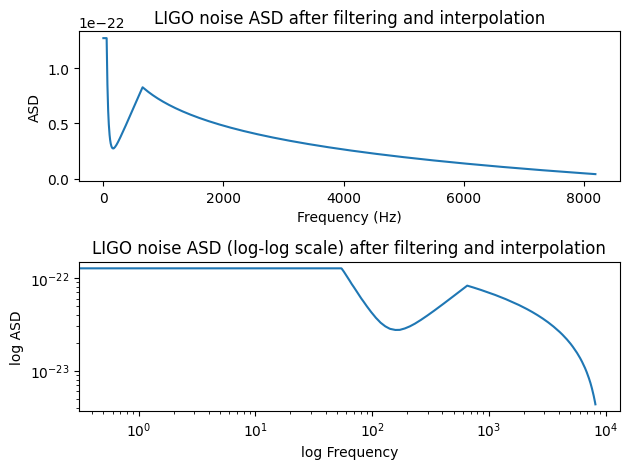

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

'Load and analyze the provided data file------------'

# Load the data from the text file
data = np.loadtxt('.\data\iLIGOSensitivity.txt')



# Extract the sampling times and data values from the data
frequency = data[:, 0]
sqrt_psd = data[:, 1]

## Modify the ASD to be constant below 50 Hz and linearly decrease to zero from 700 Hz to the Nyquist frequency
for i in range(len(sqrt_psd)):
    if frequency[i] >= 50:
        index_f50= i
        break
for i in range(len(sqrt_psd) - 1, -1, -1): 
    if frequency[i] <= 700:
        index_f700 = i
        break
interval=sqrt_psd[index_f700]/(len(sqrt_psd)-1- index_f700)
m=0
for i in range(len(sqrt_psd)):
    if frequency[i] <= 50:
        sqrt_psd[i] = sqrt_psd[index_f50]
    elif frequency[i] >= 700:
        m=m+1
        sqrt_psd[i] = sqrt_psd[index_f700]- interval * m
frequency = np.concatenate(([0], frequency))
sqrt_psd = np.concatenate(([sqrt_psd[0]], sqrt_psd))

#convert irregularly spaced frequencies into the required DFT frequencies using linear interpolation
from scipy.interpolate import interp1d
n_samples = 16384*2
samp_freq = 16384
interp_func = interp1d(frequency , sqrt_psd, kind='linear', bounds_error=False, fill_value="extrapolate")
dft_freqs = np.fft.rfftfreq(n_samples, d=1/samp_freq)
psd_interp = interp_func(dft_freqs)
frequency = dft_freqs
sqrt_psd = psd_interp

#plot the data
fig, axs = plt.subplots(2, 1)
# Plot 1
axs[0].plot(frequency, sqrt_psd)
axs[0].set_title('LIGO noise ASD after filtering and interpolation')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('ASD')

# Plot 2 on log-log scale
axs[1].loglog(frequency, sqrt_psd)
axs[1].set_title('LIGO noise ASD (log-log scale) after filtering and interpolation')
axs[1].set_xlabel('log Frequency')
axs[1].set_ylabel('log ASD')

plt.tight_layout()
plt.show()

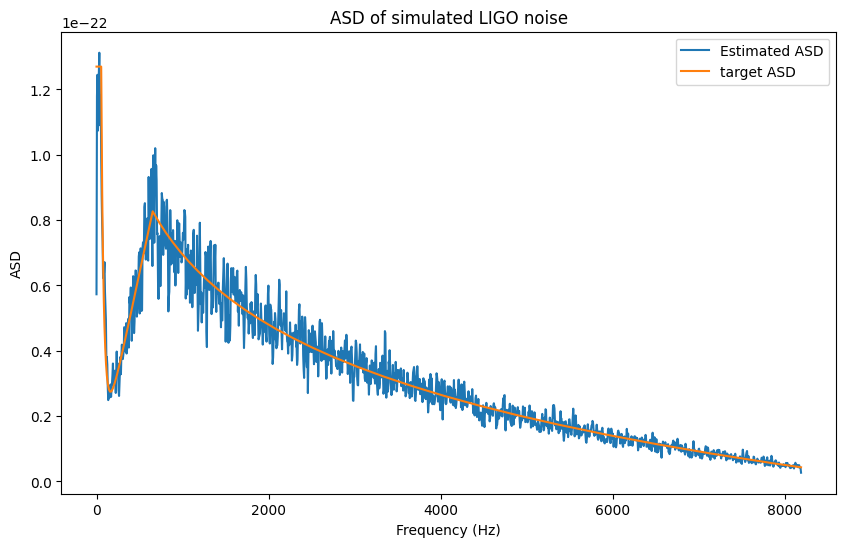

In [7]:
from function import statgaussnoisegen
## Generate a LIGO noise realization using the modified ASD
noise_ligo = statgaussnoisegen(n_samples,np.column_stack([frequency, sqrt_psd**2 ]),500, samp_freq)

# Estimate the PSD using Welch's method
f, pxx = signal.welch(noise_ligo, samp_freq, nperseg=3000)

# Plot the estimated ASD
plt.figure(figsize=(10, 6))
plt.plot(f, np.sqrt(pxx/2),label='Estimated ASD')
plt.plot(frequency,sqrt_psd, label='target ASD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD')
plt.title('ASD of simulated LIGO noise')
plt.legend() 
plt.show()

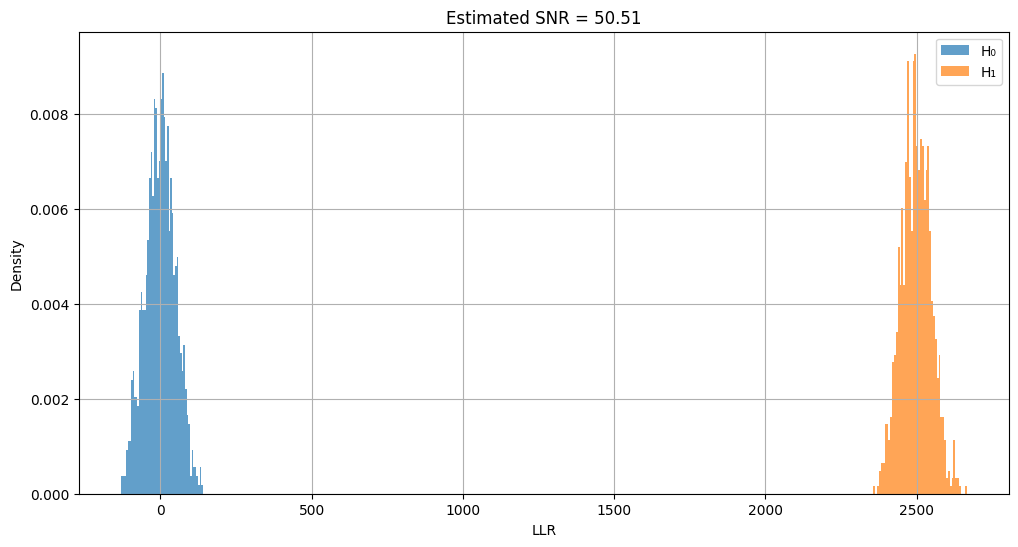

Target SNR: 50
Estimated SNR: 50.51
Mean LLR H0: -0.5155
Mean LLR H1: 2498.0960
Std LLR H0: 49.4721


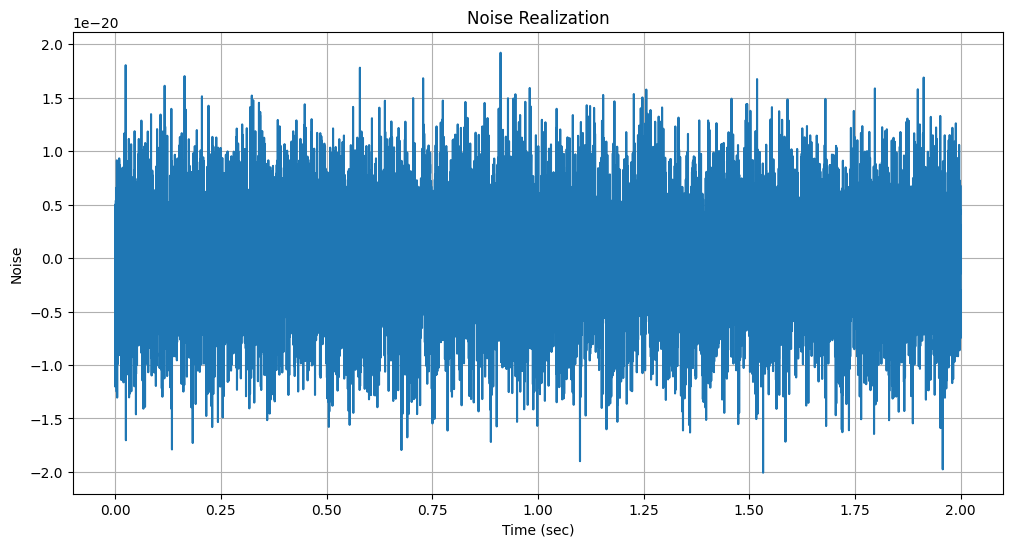

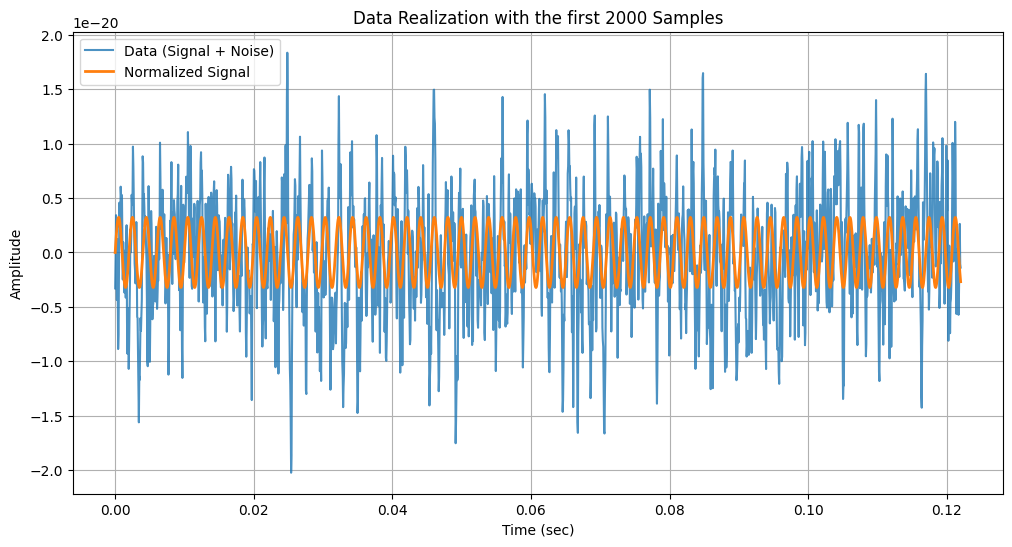

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import signal

from function import crcbgenqcsig, statgaussnoisegen, innerprod_psd

## for estimating the SNR of the LR test (binary hypotheses) from multiple data realizations

# Target SNR for the LR
snr = 50

# Data generation parameters
time_vec = np.arange(n_samples) / samp_freq

# Generate the signal that is to be normalized
a1, a2, a3 = 500, 100, 90
A = 1  # Amplitude value does not matter as it will be changed in normalization
sig_vec = crcbgenqcsig(time_vec, A, [a1, a2, a3])

# Generate the PSD vector for normalization
pos_freq = frequency
psd_pos_freq=sqrt_psd**2  # PSD is the square of the ASD
# print('psd_pos_freq shape:', psd_pos_freq.shape)

# Calculation of the norm
# Norm of signal squared is inner product of signal with itself
norm_sig_sqrd = innerprod_psd(sig_vec, sig_vec, samp_freq, psd_pos_freq)

# Normalize signal to specified SNR
sig_vec = snr * sig_vec / np.sqrt(norm_sig_sqrd)

# Test: Obtain LLR values for multiple noise realizations (H0)
n_h0_data = 1000
llr_h0 = np.zeros(n_h0_data)

for lp in range(n_h0_data):
    noise_vec = statgaussnoisegen(n_samples, np.column_stack([pos_freq, psd_pos_freq]), 500, samp_freq)
    llr_h0[lp] = innerprod_psd(noise_vec, sig_vec, samp_freq, psd_pos_freq)

# Obtain LLR for multiple data (signal + noise) realizations (H1)
n_h1_data = 1000
llr_h1 = np.zeros(n_h1_data)

for lp in range(n_h1_data):
    noise_vec = statgaussnoisegen(n_samples, np.column_stack([pos_freq, psd_pos_freq]), 500, samp_freq)
    # Add normalized signal
    data_vec = noise_vec + sig_vec
    llr_h1[lp] = innerprod_psd(data_vec, sig_vec, samp_freq, psd_pos_freq)

# Signal to noise ratio estimate
est_snr = (np.mean(llr_h1) - np.mean(llr_h0)) / np.std(llr_h0)

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(llr_h0, bins=50, alpha=0.7, label='H₀', density=True)
plt.hist(llr_h1, bins=50, alpha=0.7, label='H₁', density=True)
plt.xlabel('LLR')
plt.ylabel('Density')
plt.legend()
plt.title(f'Estimated SNR = {est_snr:.2f}')
plt.grid(True)
plt.show()

print(f"Target SNR: {snr}")
print(f"Estimated SNR: {est_snr:.2f}")
print(f"Mean LLR H0: {np.mean(llr_h0):.4f}")
print(f"Mean LLR H1: {np.mean(llr_h1):.4f}")
print(f"Std LLR H0: {np.std(llr_h0):.4f}")

# Plot a noise realization
plt.figure(figsize=(12, 6))
plt.plot(time_vec, noise_vec)
plt.xlabel('Time (sec)')
plt.ylabel('Noise')
plt.title('Noise Realization')
plt.grid(True)
plt.show()

# Plot a data realization
plt.figure(figsize=(12, 6))
plt.plot(time_vec[:2000], data_vec[:2000], label='Data (Signal + Noise)', alpha=0.8)
plt.plot(time_vec[:2000], sig_vec[:2000], label='Normalized Signal', linewidth=2)
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Data Realization with the first 2000 Samples')

plt.legend()
plt.grid(True)
plt.show()




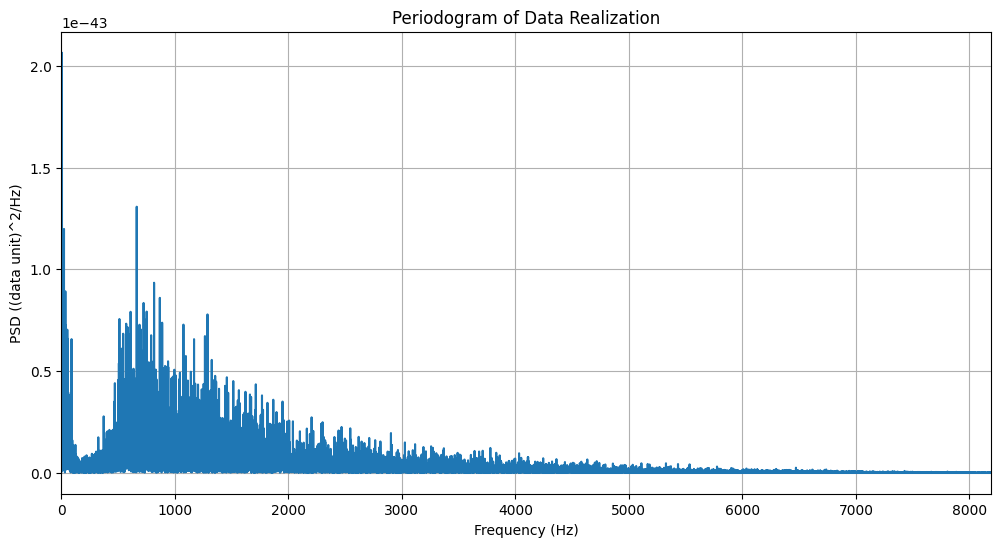

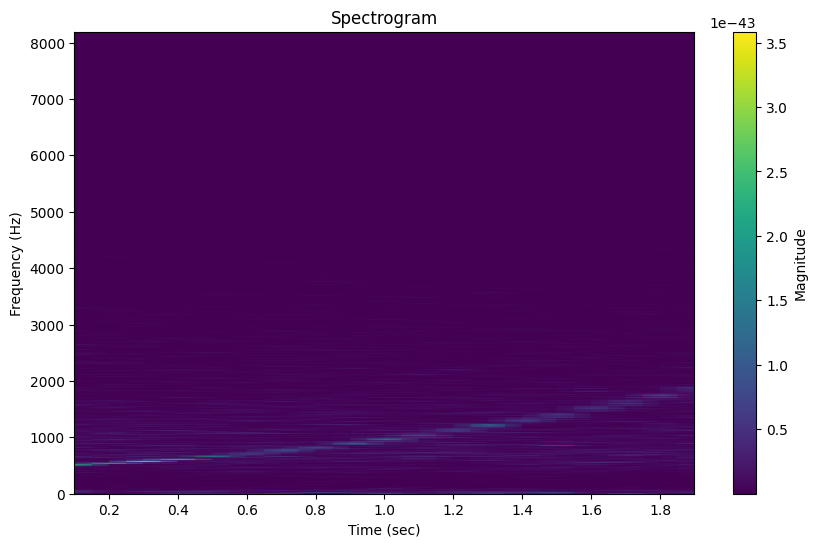

In [9]:
#Plot the periodogram of the data realization
f, Pxx = signal.periodogram(data_vec, samp_freq)
plt.figure(figsize=(12, 6))
plt.plot(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ((data unit)^2/Hz)')
plt.title('Periodogram of Data Realization')
plt.xlim(0, samp_freq / 2)
plt.grid(True)
plt.show()

# Compute the spectrogram and plot
# winLen = 0.1  # sec
# ovrlp = 0.08 # sec
winLen = 0.2  # sec
ovrlp = 0.1 # sec
winLenSmpls = int(np.floor(winLen * samp_freq))# Convert to integer number of samples
ovrlpSmpls = int(np.floor(ovrlp * samp_freq))
f, t, Sxx = signal.spectrogram(data_vec, fs=samp_freq, window='hann', nperseg=winLenSmpls, noverlap=ovrlpSmpls)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, np.abs(Sxx), shading='gouraud')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar(label='Magnitude')
plt.show()
